# Capstone Project - Family House Hunters in Raleigh, NC

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

Raleigh is the capital of the state of North Carolina and seat of Wake County in the United States. It is one of the most popular destinations for families in North Carolina.

The task at hand is to find the ideal neighborhood in the Wake County for a family with kids. The ideal neighborhood will have easy access to schools, parks and shopping malls. We will define a neighborhood as any Township or City within Wake County, NC

<img src="https://upload.wikimedia.org/wikipedia/commons/9/9d/Raleigh_photo_collage.jpg" />

## Data <a name="data"></a>

We will use data from Four Square as well as statistics data widely available from Government websites on Wake county.


Name | Source | Purpose
:---|:---|:---
**Schools** | <ul><li>NCES (National Center for Educational Statistics) *1 <li> NC Department of Public Instruction (DPI) *2</ul> | We will use two datasets from these sources to come up with the list of best schools available in a given City or Township. <ul><li>The first  dataset from NCES provides the listing of public schools within Wake County, along with Student-Teacher ratio for each school. <li>The second dataset from DPI provides the School Performance Grade in the areas of Math and Reading. </ul>We will use these 3 parameters to assess the neighborhood's schools.
**Parks** | Four Square | Using Four Square API, we can get a listing of all Parks available within Wake County. This dataset includes user rating which we will use as part of our scoring.
**Shopping Malls** | Four Square | Using Four Square API, we can get a listing of all Shopping Malls available within Wake County. This dataset includes user rating which we will use as part of our scoring.

**1 https://nces.ed.gov/ccd/schoolsearch/school_list.asp?Search=1&County=Wake%20County&State=37 <br />
**2 https://www.dpi.nc.gov/districts-schools/testing-and-school-accountability/school-accountability-and-reporting/accountability-data-sets-and-reports


### Schools Data Set
Retrieve both school datasets - NCES and DPI - and combine them using the school code to come up with average Student-Teacher ratio, Math performance grade and English performance grade for each city within the data set

#### 1. Get Avg. Student-Teacher Ratio for each City

In [15]:
# Get average Student Teacher Ratio for each City through NCES excel file - https://nces.ed.gov/ccd/schoolsearch/school_list.asp?Search=1&County=Wake%20County&State=37
import pandas as pd
from botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='5GRC2AOaMQRndXdu7FZV6Up-e7lWrmlkMHKJKpMLK-Of',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

streaming_body_1 = cos.get_object(Bucket='capstone-donotdelete-pr-hqx7tsn0z66mmk', Key='ncesdata_AC90E989.xlsx')['Body']
dfSchool1 = pd.read_excel(streaming_body_1)

#Convert Student Teacher Ratio to numeric and remove NaN values
dfSchool1['Student Teacher Ratio*']=pd.to_numeric(dfSchool1['Student Teacher Ratio*'], errors='coerce')
dfSchool1 = dfSchool1[dfSchool1['Student Teacher Ratio*'].notna()]

dfSchool1['City'] = dfSchool1['City'].replace("Fuquay-Varina", "Fuquay Varina")


#Get average Student Teacher ratio by city 
dfCityList1 = dfSchool1.groupby(['City'], as_index=False)['Student Teacher Ratio*'].mean()
dfCityList1.rename(columns={'Student Teacher Ratio*': 'Student_Teacher_Ratio'}, inplace=True)

dfCityList1

,City,Student_Teacher_Ratio
0,Apex,16.761111
1,Cary,15.919355
2,Fuquay Varina,16.283333
3,Garner,14.875000
4,Holly Springs,16.655556
5,Knightdale,14.400000
6,Morrisville,16.375000
7,Raleigh,15.360204
8,Rolesville,17.400000
9,Wake Forest,16.315385


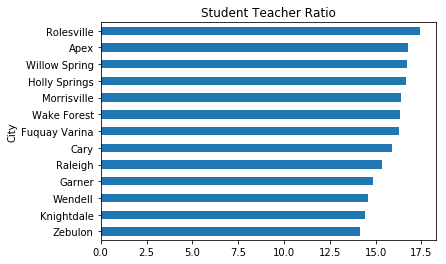

In [16]:
from matplotlib import pyplot as plt
ax = dfCityList1.sort_values('Student_Teacher_Ratio').plot.barh(x='City', y='Student_Teacher_Ratio', rot=0)
plt.title("Student Teacher Ratio")
plt.gca().get_legend().remove()


### 2. Get Avg. English and Math SPG scores for each City

In [6]:
#NC DPI -  https://files.nc.gov/dpi/spg-report2019_final.xlsx
excelFile = pd.ExcelFile('https://files.nc.gov/dpi/spg-report2019_final.xlsx')

In [17]:
#Filter Wake County school performance
dfSchool2 = pd.read_excel(excelFile, 'SPG Data For Download')
dfSchool2=dfSchool2.query('subgroup == "ALL" & lea_name == "Wake County Schools"')

# Get City from School1 dataset by joining on School Code
dfSchool1['State School ID'] = dfSchool1['State School ID'].map(lambda x: x.lstrip('NC-').replace('-',''))
dfSchools = pd.merge(dfSchool2, dfSchool1[['State School ID','City', 'Student Teacher Ratio*']] , left_on='school_code', right_on='State School ID', how='inner')

dfCityList2 = dfSchools.groupby(['City'], as_index=False)[['rd_spg_score', 'ma_spg_score']].mean()
dfCityList2.rename(columns={'rd_spg_score': 'Reading_Score', 'ma_spg_score' : 'Math_Score', 'Student Teacher Ratio*' : 'Student_Teacher_Ratio'}, inplace=True)
dfCityList2

,City,Reading_Score,Math_Score
0,Apex,75.333333,77.600000
1,Cary,75.454545,77.727273
2,Fuquay Varina,66.000000,63.600000
3,Garner,57.000000,57.300000
4,Holly Springs,76.166667,75.333333
5,Knightdale,48.500000,49.500000
6,Morrisville,75.333333,78.000000
7,Raleigh,63.056338,63.816901
8,Rolesville,67.000000,63.666667
9,Wake Forest,73.166667,73.000000


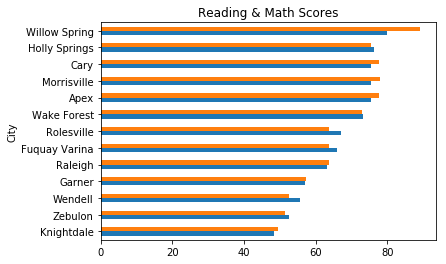

In [18]:
from matplotlib import pyplot as plt
ax = dfCityList2.sort_values('Reading_Score').plot.barh(x='City', y=['Reading_Score', 'Math_Score'], rot=0)
plt.title("Reading & Math Scores")
plt.gca().get_legend().remove()

### 3. Merge both City datasets to get a combined Student Teacher Ratio, English SPG Score, Match SPG Score

In [19]:
dfCityList =pd.merge(dfCityList1, dfCityList2, on="City", how="inner")
dfCityList

,City,Student_Teacher_Ratio,Reading_Score,Math_Score
0,Apex,16.761111,75.333333,77.600000
1,Cary,15.919355,75.454545,77.727273
2,Fuquay Varina,16.283333,66.000000,63.600000
3,Garner,14.875000,57.000000,57.300000
4,Holly Springs,16.655556,76.166667,75.333333
5,Knightdale,14.400000,48.500000,49.500000
6,Morrisville,16.375000,75.333333,78.000000
7,Raleigh,15.360204,63.056338,63.816901
8,Rolesville,17.400000,67.000000,63.666667
9,Wake Forest,16.315385,73.166667,73.000000


### Parks Data Set
Using Four Square api, get the average user rating for parks for each City in Wake County

In [20]:
## Get the list of parks in Wake County, NC using Four Square Explore api
import requests # library to handle requests
from pandas.io.json import json_normalize
import numpy as np

CLIENT_ID = 'FKZWMIYFOGYOXXJIIUVJ0CZL2J2RU3GOFPEECXRICF0GBCW4' # your Foursquare ID
CLIENT_SECRET = 'L5C1LM5Q4FNY33ZTSOWKVWB15GU4CNY54IFPD3WDYGJBMWDB' # your Foursquare Secret
VERSION = '20200731'
LIMIT = 30
NEAR = "Wake County, NC"
search_query="Parks"
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&near={}&v={}&query={}&limit=100'.format(CLIENT_ID, CLIENT_SECRET, NEAR, VERSION, search_query)
results = requests.get(url).json()

## Using Four Square Venue Details api, get user ratings for each park
parkVenues = results['response']['groups'][0]['items']

# tranform venues into a dataframe
dfPark = json_normalize(parkVenues)

#Get user ratings for the parks
venues_ids= dfPark['venue.id']   
ratings=[]

for venue_id in venues_ids.values.tolist():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        venues_rating=result['response']['venue']['rating']
        ratings=ratings+[venues_rating]
    except IndexError:
        #print('No data available for id=',venue_id)
        ratings=ratings+[0]
    except KeyError:
        #print('No data available for id=',venue_id)
        ratings=ratings+[0]

In [21]:
#Add User Ratings to the Park data set
dfPark['UserRatings'] = ratings
dfPark['UserRatings'] = dfPark['UserRatings'].replace(0, np.NaN)

#Get average User rating for parks by City
dfCityList3 = dfPark.groupby(['venue.location.city'], as_index=False)['UserRatings'].mean()

#Merge with main City Data set
#dfCityList
dfCityListWithPark = pd.merge(dfCityList, dfCityList3, left_on="City", right_on="venue.location.city", how="left")
dfCityListWithPark=dfCityListWithPark.drop(['venue.location.city'],axis=1)
dfCityListWithPark['UserRatings'] = dfCityListWithPark['UserRatings'].fillna(0)
dfCityListWithPark.rename(columns={'UserRatings': 'ParkUserRatings'}, inplace=True)
dfCityListWithPark

,City,Student_Teacher_Ratio,Reading_Score,Math_Score,ParkUserRatings
0,Apex,16.761111,75.333333,77.600000,7.733333
1,Cary,15.919355,75.454545,77.727273,7.514286
2,Fuquay Varina,16.283333,66.000000,63.600000,0.000000
3,Garner,14.875000,57.000000,57.300000,7.800000
4,Holly Springs,16.655556,76.166667,75.333333,8.000000
5,Knightdale,14.400000,48.500000,49.500000,8.600000
6,Morrisville,16.375000,75.333333,78.000000,7.100000
7,Raleigh,15.360204,63.056338,63.816901,7.492157
8,Rolesville,17.400000,67.000000,63.666667,8.300000
9,Wake Forest,16.315385,73.166667,73.000000,7.880000


### Shopping Malls Data Set
Using Four Square api, get the average user rating for shopping malls for each City in Wake County

In [22]:
## Get the list of Shopping Malls in Wake County, NC using Four Square Explore api
search_query="Shopping Malls"
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&near={}&v={}&query={}&limit=100'.format(CLIENT_ID, CLIENT_SECRET, NEAR, VERSION, search_query)
results = requests.get(url).json()


In [23]:
## Using Four Square Venue Details api, get user ratings for each park
mallVenues = results['response']['groups'][0]['items']

# tranform venues into a dataframe
dfMall = json_normalize(mallVenues)

#Get user ratings for the parks
venues_ids= dfMall['venue.id']   
ratings=[]

for venue_id in venues_ids.values.tolist():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)
    result = requests.get(url).json()
    try:
        venues_rating=result['response']['venue']['rating']
        ratings=ratings+[venues_rating]
    except KeyError:
        #print('No data available for id=',venue_id)
        ratings=ratings+[0]

#Add User Ratings to the Park data set
dfMall['UserRatings'] = ratings
dfMall['UserRatings'] = dfMall['UserRatings'].replace(0, np.NaN)

#Get average User rating for parks by City
dfCityList4 = dfMall.groupby(['venue.location.city'], as_index=False)['UserRatings'].mean()

#Merge with main City Data set
#dfCityList
dfCityListWithMall = pd.merge(dfCityListWithPark, dfCityList4, left_on="City", right_on="venue.location.city", how="left")
dfCityListWithMall=dfCityListWithMall.drop(['venue.location.city'],axis=1)
dfCityListWithMall['UserRatings'] = dfCityListWithMall['UserRatings'].fillna(0)
dfCityListWithMall.rename(columns={'UserRatings': 'MallUserRatings'}, inplace=True)
dfCityListWithMall

,City,Student_Teacher_Ratio,Reading_Score,Math_Score,ParkUserRatings,MallUserRatings
0,Apex,16.761111,75.333333,77.600000,7.733333,7.60000
1,Cary,15.919355,75.454545,77.727273,7.514286,7.10000
2,Fuquay Varina,16.283333,66.000000,63.600000,0.000000,0.00000
3,Garner,14.875000,57.000000,57.300000,7.800000,0.00000
4,Holly Springs,16.655556,76.166667,75.333333,8.000000,7.40000
5,Knightdale,14.400000,48.500000,49.500000,8.600000,0.00000
6,Morrisville,16.375000,75.333333,78.000000,7.100000,7.45000
7,Raleigh,15.360204,63.056338,63.816901,7.492157,7.15625
8,Rolesville,17.400000,67.000000,63.666667,8.300000,0.00000
9,Wake Forest,16.315385,73.166667,73.000000,7.880000,0.00000


## Methodology <a name="methodology"></a>
We will perform explanatory data analysis to first try to rank all cities in Wake County,NC based on a combination of Student Teacher Ratio, Reading SPG Scores, Math SPG Scores, Park Ratings & Shopping Mall Ratings. 

In addition, using linear regression, we will identify if there is any correlation between Student Teacher Ratio & Total SPG Scores for all schools in Wake County, NC.

### 1. Ranking of Cities based on Student Teacher Ratio, Math/Reading Scores, Parks and Shopping Malls
Assign a ranking to each city in Wake County, NC based on below weightage

Measure | Weightage
:---|:---
**Student Teacher Ratio** | 25% 
**Reading SPG Scores** | 30% 
**Math SPG Scores** | 30% 
**Park Rating** | 10% 
**Shopping Mall Rating** | 5%
**Total** | **100%**


In [24]:
#Calculate a City Rating based on below formula:
# Weightage on Student Teacher Ratio : 25%
# Weightage on Math and Reading Scores : 30% each
# Weightage on Parks: 10 %
# Weightage on Mall: 5 %
dfFinal = dfCityListWithMall
dfFinal['Final_Score'] = dfCityListWithMall.apply(lambda row: 0.25*(1000.0/(row['Student_Teacher_Ratio'])) + 0.3*row['Reading_Score'] + 0.3*row['Math_Score'] + 0.10*row['ParkUserRatings'] + 0.05*row['MallUserRatings'], axis=1)
dfFinal['rank'] = dfFinal['Final_Score'].rank(ascending=False)
dfFinal

,City,Student_Teacher_Ratio,Reading_Score,Math_Score,ParkUserRatings,MallUserRatings,Final_Score,rank
0,Apex,16.761111,75.333333,77.600000,7.733333,7.60000,61.948812,4.0
1,Cary,15.919355,75.454545,77.727273,7.514286,7.10000,62.765128,2.0
2,Fuquay Varina,16.283333,66.000000,63.600000,0.000000,0.00000,54.233122,9.0
3,Garner,14.875000,57.000000,57.300000,7.800000,0.00000,51.876723,10.0
4,Holly Springs,16.655556,76.166667,75.333333,8.000000,7.40000,61.630007,5.0
5,Knightdale,14.400000,48.500000,49.500000,8.600000,0.00000,47.621111,13.0
6,Morrisville,16.375000,75.333333,78.000000,7.100000,7.45000,62.349676,3.0
7,Raleigh,15.360204,63.056338,63.816901,7.492157,7.15625,55.444825,7.0
8,Rolesville,17.400000,67.000000,63.666667,8.300000,0.00000,54.397816,8.0
9,Wake Forest,16.315385,73.166667,73.000000,7.880000,0.00000,59.960961,6.0


### 2. Check if there is any correlation between Student-Teacher Ratio and total SPG scores
Using the Schools dataset, let's validate if there is any correlation between Student-Teacher ratio and total SPG scores

First, let's check the frequency distribution of the 2 variables

Text(0, 0.5, 'Frequency')

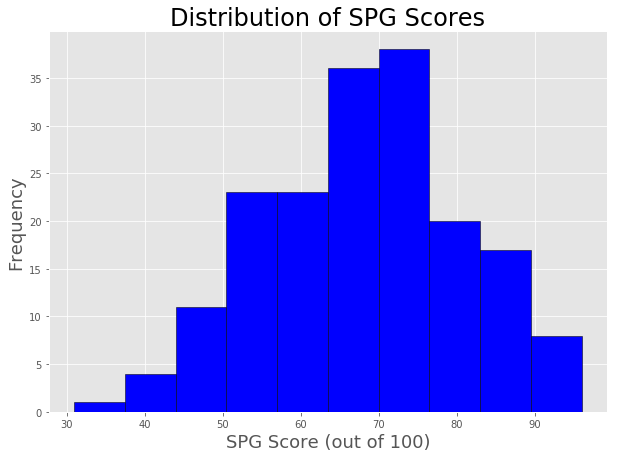

In [25]:
#Distribution of total SPG Scores
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# histogram of the SPG Score
dfSchools['spg_score'].plot(kind='hist', color='blue', edgecolor='black', figsize=(10,7))
plt.title('Distribution of SPG Scores', size=24)
plt.xlabel('SPG Score (out of 100)', size=18)
plt.ylabel('Frequency', size=18)

Text(0, 0.5, 'Frequency')

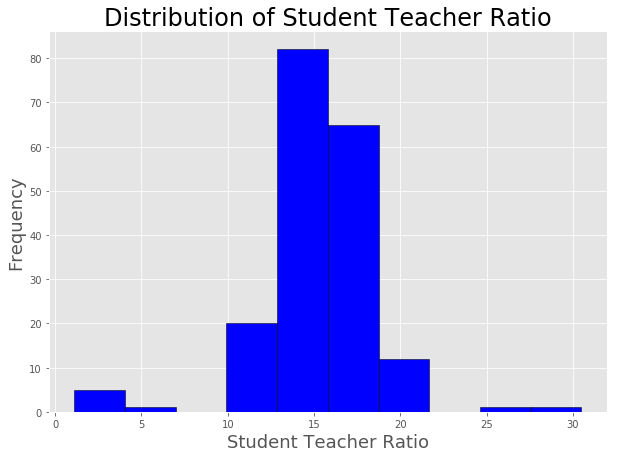

In [26]:

# histogram of the Student Teacher Ratio
dfSchools['Student Teacher Ratio*'].plot(kind='hist', color='blue', edgecolor='black', figsize=(10,7))
plt.title('Distribution of Student Teacher Ratio', size=24)
plt.xlabel('Student Teacher Ratio', size=18)
plt.ylabel('Frequency', size=18)

### Residual Plot
Let's check the residual plot to confirm if linear regression can be used for the 2 variables. If the points in a residual plot are randomly dispersed around the horizontal axis, a linear regression model is appropriate for the data

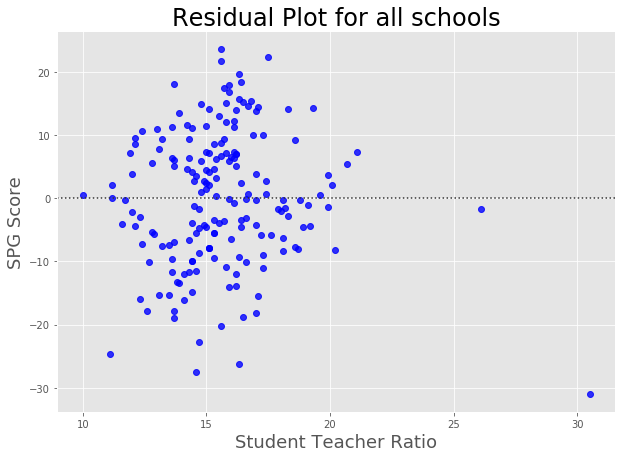

In [31]:
# residual plot 500 males
fig = plt.figure(figsize=(10, 7))
sns.residplot(dfSchools['Student Teacher Ratio*'], dfSchools['spg_score'], color='blue')

# title and labels
plt.title('Residual Plot for all schools', size=24)
plt.xlabel('Student Teacher Ratio', size=18)
plt.ylabel('SPG Score', size=18);

Based on this, it seems appropriate to use linear regression


### Scatter Plot

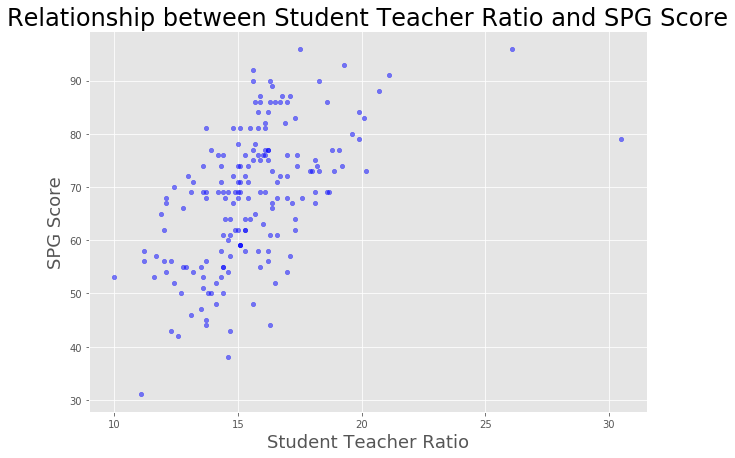

In [63]:
#Scatter plot
ax1 = dfSchools.plot(kind='scatter', x='Student Teacher Ratio*', y='spg_score', color='blue', alpha=0.5, figsize=(10, 7))
plt.title('Relationship between Student Teacher Ratio and SPG Score', size=24)
plt.xlabel('Student Teacher Ratio', size=18)
plt.ylabel('SPG Score', size=18);

### Linear Regression
Identify relation between Student Teacher Ratio and SPG Score for a sample population of 70 schools

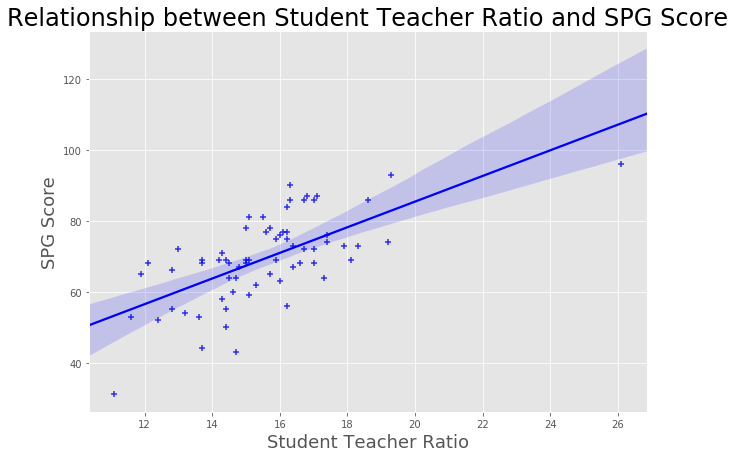

In [27]:
import seaborn as sns
sample_schools = dfSchools.sample(70)
# regression plot using seaborn
fig = plt.figure(figsize=(10, 7))
sns.regplot(x=sample_schools['Student Teacher Ratio*'], y=sample_schools['spg_score'], color='blue', marker='+')

# Legend, title and labels.
plt.title('Relationship between Student Teacher Ratio and SPG Score', size=24)
plt.xlabel('Student Teacher Ratio', size=18)
plt.ylabel('SPG Score', size=18);

### Pearson Correlation Coefficient
Get the Pearson Correlation Coefficient. A rule of thumb for interpreting the size of the correlation coefficient is the following:
<ul>
<li>1–0.8 → Very strong
<li>0.799–0.6 → Strong
<li>0.599–0.4 → Moderate
<li>0.399–0.2 → Weak
<li>0.199–0 → Very Weak
    </ul>

In [28]:
#Pearson correlation coefficient
sample_schools[['Student Teacher Ratio*','spg_score']].corr()

,Student Teacher Ratio*,spg_score
Student Teacher Ratio*,1.00000,0.65401
spg_score,0.65401,1.00000


A correlation coefficient of 0.65401 indicates a **Strong positive correlation** between Student Teacher Ratio and SPG score 

## Results and Discussion <a name="results"></a>

### 1. Based on the calculated rankings, the top 5 cities for families in Wake County, NC are given below

In [33]:
dfFinal.sort_values('rank').head(5)

,City,Student_Teacher_Ratio,Reading_Score,Math_Score,ParkUserRatings,MallUserRatings,Final_Score,rank
11,Willow Spring,16.700000,80.000000,89.000000,0.000000,0.00,65.670060,1.0
1,Cary,15.919355,75.454545,77.727273,7.514286,7.10,62.765128,2.0
6,Morrisville,16.375000,75.333333,78.000000,7.100000,7.45,62.349676,3.0
0,Apex,16.761111,75.333333,77.600000,7.733333,7.60,61.948812,4.0
4,Holly Springs,16.655556,76.166667,75.333333,8.000000,7.40,61.630007,5.0


The key observations are:
1. Even though there are no parks or malls in Willow Spring, it came out at the top spot as more weightage has been given to School Ratings (85%) rather than other amenities.
2. Holly Springs has 2nd highest Reading & Math scores, but due to a comparatively high Student to Teacher Ratio, it got a lower ranking than Cary, Morrisville & Apex
3. Between Apex and Morrisville, even though both have equally good Reading & Math scores and Shopping malls, Apex lost out due to higher Student-Teacher ratio.

### 2. Based on the correlation analysis between Student Teacher Ratio and School SPG Score

Pearson correlation coefficient of **0.65401** indicates a **Strong positive correlation** between Student Teacher Ratio and SPG score. 

## Conclusion <a name="conclusion"></a>

The goal of this exercise was to identify the best neighborhood to move in for a family with kids in Wake County, NC. We have used FourSquare api to explore all Parks and Shopping malls in the cities and use the User Ratings to identify the ideal family location. Using FourSquare data, along with data available in governmental websites, we were able to narrow down the top 5 cities within Wake County.

As schools are an important criteria to identify the ideal neighborhood, we also validated whether there is any correlation between Student Teacher Ratio and Total SPG Score. This results from this was surprising. Common understanding is that lower Student Teacher Ratio means Teachers would pay more attention to a smaller class size and result in a higher student performance. But since there is a positive correlation between Student Teacher Ratio and Total SPG Score, this common understanding doesn't hold true for schools in Wake County. So there could be other attributes that may have an impact to Total SPG Score such as ethnicity, gender or teaching quality which would be worth exploring further.